https://archive.ics.uci.edu/ml/datasets/Taxi+Service+Trajectory+-+Prediction+Challenge%2C+ECML+PKDD+2015

http://www.geolink.pt/ecmlpkdd2015-challenge/dataset.html

- Objetivos:
    - EDA
    - Clustering
    
    
In this challenge, we propose you to build a predictive framework able to infer the final destination of each taxi ride based on their (initial) partial trajectories. This challenge is divisible in two different outputs: (a) the destination coordinates (WGS84) and (b) the total trip's travel time (counting from the service's starting point, in seconds).

References:

- https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
plt.figure(figsize=(15,5));
sns.set(rc={'figure.figsize':(15,5), 'xtick.direction':'in'});

<Figure size 1080x360 with 0 Axes>

EDA feita com amostra do conjunto total (2 dias apenas).

In [3]:
dtypes={
    'CALL_TYPE':'category',
    'ORIGIN_CALL':'category',
    'ORIGIN_STAND':'category',
    'TAXI_ID':'category',
    'DAY_TYPE':'category'
}

df = pd.read_csv('Porto_taxi_data_training.csv', dtype=dtypes)

# dropping and converting some columns
# TRIP_ID: id, DAY_TYPE: calculado errado no dataset.
df.drop(['TRIP_ID','DAY_TYPE' ], axis=1, inplace=True)
df.TIMESTAMP = pd.to_datetime(df.TIMESTAMP, unit='s')

In [4]:
df.head()

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE
0,C,NaN,NaN,20000589,2013-07-01 00:00:58,False,"[[-8.618643, 41.141412], [-8.618499, 41.141376..."
1,B,NaN,7,20000596,2013-07-01 00:08:23,False,"[[-8.639847, 41.159825999999995], [-8.64035099..."
2,C,NaN,NaN,20000320,2013-07-01 00:02:31,False,"[[-8.612964, 41.140359000000004], [-8.613378, ..."
3,C,NaN,NaN,20000520,2013-07-01 00:00:54,False,"[[-8.574678, 41.151951], [-8.574705, 41.151942..."
4,C,NaN,NaN,20000337,2013-07-01 00:04:51,False,"[[-8.645994, 41.18049], [-8.645949, 41.180517]..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7732 entries, 0 to 7731
Data columns (total 7 columns):
CALL_TYPE       7732 non-null category
ORIGIN_CALL     1853 non-null category
ORIGIN_STAND    3934 non-null category
TAXI_ID         7732 non-null category
TIMESTAMP       7732 non-null datetime64[ns]
MISSING_DATA    7732 non-null bool
POLYLINE        7732 non-null object
dtypes: bool(1), category(4), datetime64[ns](1), object(1)
memory usage: 249.2+ KB


**CALL_TYPE**

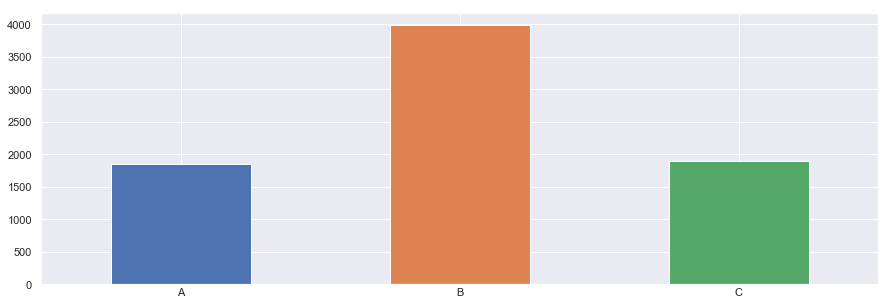

In [26]:
ax = df.CALL_TYPE.value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

- 'A' if this trip was dispatched from the central;
- 'B' if this trip was demanded directly to a taxi driver at a specific stand;
- 'C' otherwise (i.e. a trip demanded on a random street).

**ORIGIN_CALL**

Essa coluna serve apenas quando ```CALL_TYPE='A'```. Conta telefones que ligaram para a central pedindo uma corrida.

In [28]:
callers = df.ORIGIN_CALL.value_counts()[:10]
callers

2002     331
63882     40
2001      22
6654       7
2024       6
5591       5
13168      5
6584       5
14045      5
9327       4
Name: ORIGIN_CALL, dtype: int64

Um único número fez 331 chamadas. Será que é sempre o mesmo taxista que atende?

In [89]:
for caller in callers.index:
    tax_qt = df[df.ORIGIN_CALL == caller].TAXI_ID.value_counts().map(lambda x: x>0).sum()
    print('Caller: {0} --->  Diff. drivers: {1}'.format(caller, tax_qt))

Caller: 2002 --->  Diff. drivers: 218
Caller: 63882 --->  Diff. drivers: 38
Caller: 2001 --->  Diff. drivers: 20
Caller: 6654 --->  Diff. drivers: 7
Caller: 2024 --->  Diff. drivers: 6
Caller: 5591 --->  Diff. drivers: 5
Caller: 13168 --->  Diff. drivers: 5
Caller: 6584 --->  Diff. drivers: 5
Caller: 14045 --->  Diff. drivers: 5
Caller: 9327 --->  Diff. drivers: 4


Negativo! Vários taxistas são chamados para as corridas. Isso pode significar que o chamado é feito de acordo com a localização mais próxima entre usuário e taxista.

**ORIGIN_STAND**

In [92]:
df.ORIGIN_STAND.value_counts()[:10]

15    396
57    273
18    215
9     173
13    151
36    138
33    134
7     120
12    105
10     96
Name: ORIGIN_STAND, dtype: int64

In [93]:
print('Média de chamados por posto: '+str(df.ORIGIN_STAND.value_counts().mean()))
print('Desvio padrão de chamados por posto: '+str(df.ORIGIN_STAND.value_counts().std()))

Média de chamados por posto: 64.49180327868852
Desvio padrão de chamados por posto: 67.99917228682999


Esses são os postos mais requisitados

In [96]:
print(df.TIMESTAMP.sort_values().min())
print(df.TIMESTAMP.sort_values().max())

2013-07-01 00:00:53
2013-07-02 16:17:26


**TIME_STAMP**

In [94]:
df.TIMESTAMP.sort_values().describe()

count                    7732
unique                   7489
top       2013-07-02 13:11:53
freq                        3
first     2013-07-01 00:00:53
last      2013-07-02 16:17:26
Name: TIMESTAMP, dtype: object

In [11]:
dft = df.set_index('TIMESTAMP')

Frequência de corridas por hora

In [12]:
dft['hour'] = dft.index.hour

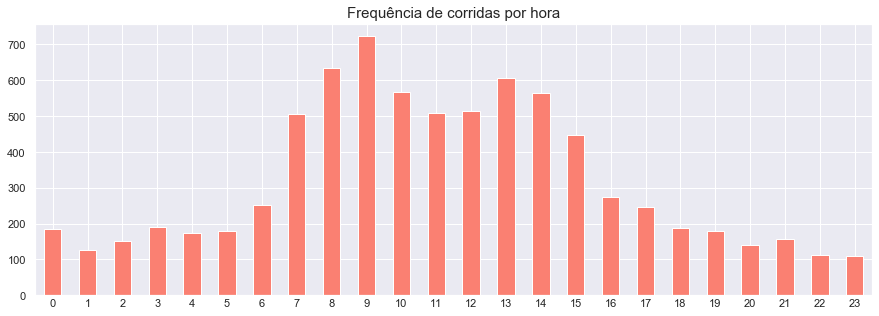

In [14]:
ax = dft['hour'].value_counts().sort_index(ascending=True).plot(kind='bar', color='salmon')
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.title('Frequência de corridas por hora', fontsize=15)
plt.show()

- 3h: tem relação com o final de semana?
- 8h: tem ralção com a ida para o trabalho?
- 14h: tem relação com o almoço?
- 17h: tem relação com fim do expediente?

Investigando hora e dia

In [15]:
for mth in df.TIMESTAMP.dt.month.unique():
    print(dft.CALL_TYPE[dft.index.month==mth].groupby(pd.Grouper(freq='h')).size())

TIMESTAMP
2013-07-01 00:00:00     91
2013-07-01 01:00:00     57
2013-07-01 02:00:00     63
2013-07-01 03:00:00     93
2013-07-01 04:00:00     73
2013-07-01 05:00:00     83
2013-07-01 06:00:00    128
2013-07-01 07:00:00    272
2013-07-01 08:00:00    329
2013-07-01 09:00:00    397
2013-07-01 10:00:00    311
2013-07-01 11:00:00    255
2013-07-01 12:00:00    276
2013-07-01 13:00:00    306
2013-07-01 14:00:00    299
2013-07-01 15:00:00    297
2013-07-01 16:00:00    262
2013-07-01 17:00:00    245
2013-07-01 18:00:00    188
2013-07-01 19:00:00    179
2013-07-01 20:00:00    139
2013-07-01 21:00:00    157
2013-07-01 22:00:00    112
2013-07-01 23:00:00    111
2013-07-02 00:00:00     93
2013-07-02 01:00:00     68
2013-07-02 02:00:00     88
2013-07-02 03:00:00     97
2013-07-02 04:00:00    101
2013-07-02 05:00:00     97
2013-07-02 06:00:00    123
2013-07-02 07:00:00    235
2013-07-02 08:00:00    306
2013-07-02 09:00:00    325
2013-07-02 10:00:00    257
2013-07-02 11:00:00    253
2013-07-02 12:00:0

Mês e dia foram selecionados sendo que não há mais de um dia em um mês. Temos feriados e dias normais?

In [289]:
pd.read_csv('Porto_taxi_data_training.csv')

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643, 41.141412], [-8.618499, 41.141376..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847, 41.159825999999995], [-8.64035099..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964, 41.140359000000004], [-8.613378, ..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678, 41.151951], [-8.574705, 41.151942..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994, 41.18049], [-8.645949, 41.180517]..."
5,1372636965620000231,C,NaN,NaN,20000231,1372636965,A,False,"[[-8.615502, 41.140674], [-8.614854, 41.140926..."
6,1372637210620000456,C,NaN,NaN,20000456,1372637210,A,False,"[[-8.57952, 41.145948000000004], [-8.580942, 4..."
7,1372637299620000011,C,NaN,NaN,20000011,1372637299,A,False,"[[-8.617563, 41.146182], [-8.617526999999999, ..."
8,1372637274620000403,C,NaN,NaN,20000403,1372637274,A,False,"[[-8.611794, 41.140557], [-8.611785, 41.140575..."
9,1372637905620000320,C,NaN,NaN,20000320,1372637905,A,False,"[[-8.615907, 41.140557], [-8.614449, 41.141087..."
